In [1]:
import pandas as pd
import numpy   as np
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_log_error
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [3]:
display(train_data.shape)
display(train_data.head())
display(test_data.shape)
display(test_data.head())

(1460, 81)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1459, 80)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
X_train = train_data.select_dtypes(include=['number']).copy()
X_train = X_train.drop(['SalePrice'], axis=1)
y_train = train_data["SalePrice"]
X_test  = test_data.select_dtypes(include=['number']).copy()

In [5]:
cols = ['LotFrontage', 'LotArea', 'GrLivArea']
X_train = X_train[cols]
X_test = X_test[cols]

In [6]:
X_train.agg(['mean','max','min'])

,LotFrontage,LotArea,GrLivArea
mean,70.049958,10516.828082,1515.463699
max,313.000000,215245.000000,5642.000000
min,21.000000,1300.000000,334.000000


In [7]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

In [8]:
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 500}


In [9]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
import pickle
with open('data/house_model_col3.pkl','wb') as f:
    pickle.dump(regressor, f)

In [11]:
with open('data/house_model_col3.pkl','rb') as f:
    loaded_model = pickle.load(f)

In [12]:
predictions = regressor.predict(X_test)

In [13]:
solution   = pd.read_csv('data/solution.csv')
y_true     = solution["SalePrice"]

RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The score is %.5f" % RMSLE )

The score is 0.26333


In [14]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

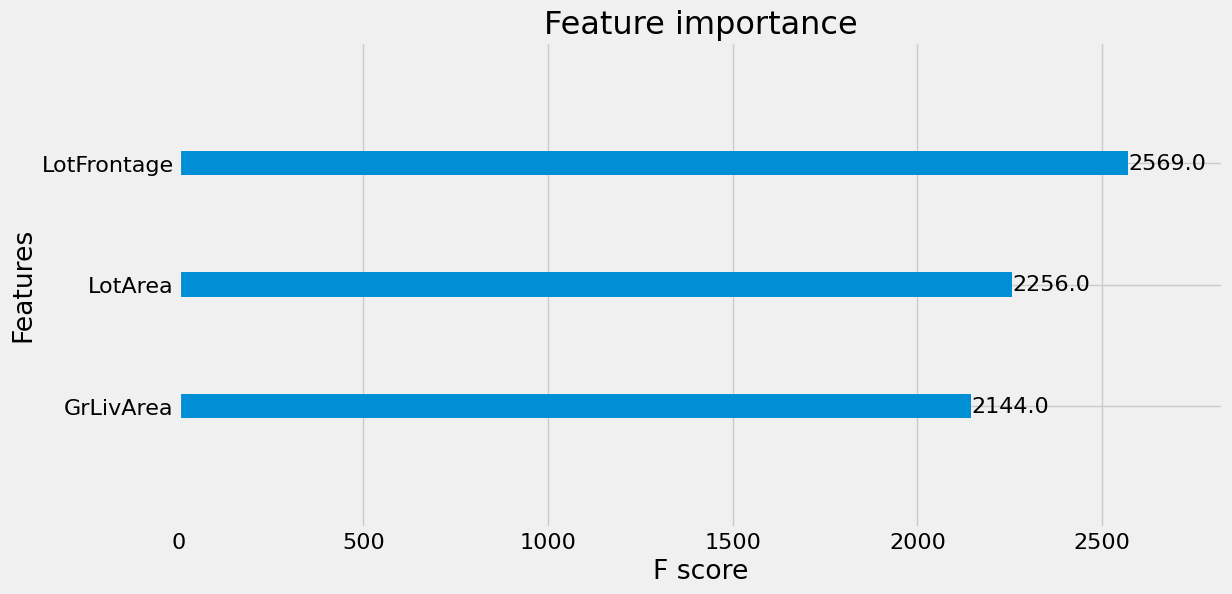

In [15]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

In [16]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


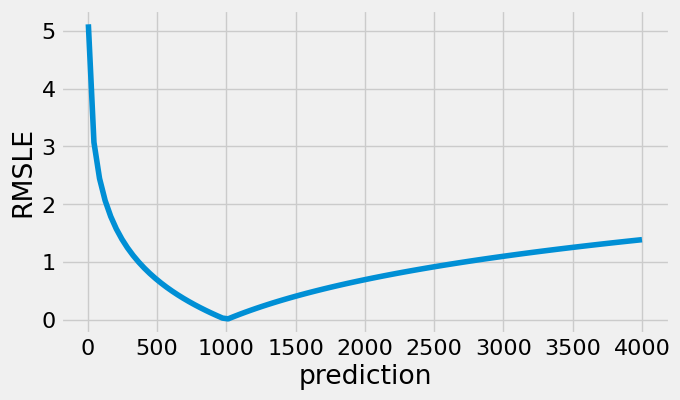

In [17]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()